# Problem 3: DIY Dataset – Superstore Sales

Dataset: Tableau Sample Superstore (Orders table)

Source URL: https://www.kaggle.com/datasets/konstantinognev/sample-superstorecsv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (8,4)

df = pd.read_csv("Sample - Superstore.csv",
                 encoding="latin1",
                 parse_dates=["Order Date", "Ship Date"])

df.head()


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df.info()
df.describe(include="all").T


In [9]:
# 1) Missing values
def handle_missing_values(df, strategy="drop", fill_value=None, subset=None):
    work_df = df.copy()
    if subset is None:
        subset = work_df.columns

    mask = work_df[subset].isna().any(axis=1)
    before = work_df[mask].copy()

    if not mask.any():
        return work_df, None, None

    if strategy == "drop":
        work_df = work_df[~mask]
    elif strategy == "fill":
        if fill_value is None:
            work_df[subset] = work_df[subset].fillna(work_df[subset].median(numeric_only=True))
        else:
            work_df[subset] = work_df[subset].fillna(fill_value)

    after = work_df.loc[before.index.intersection(work_df.index)]
    return work_df, before, after


# 2) Duplicates
def remove_duplicates(df, subset=None):
    work_df = df.copy()
    mask = work_df.duplicated(subset=subset, keep="first")
    before = work_df[mask].copy()

    if not mask.any():
        return work_df, None, None

    work_df = work_df.drop_duplicates(subset=subset, keep="first")
    after = work_df.iloc[0:0].copy()
    return work_df, before, after


# 3) Outliers (IQR)
def handle_outliers_iqr(df, column, method="cap"):
    work_df = df.copy()
    q1 = work_df[column].quantile(0.25)
    q3 = work_df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    mask = (work_df[column] < lower) | (work_df[column] > upper)
    before = work_df[mask].copy()

    if not mask.any():
        return work_df, None, None

    if method == "cap":
        work_df.loc[work_df[column] < lower, column] = lower
        work_df.loc[work_df[column] > upper, column] = upper
        after = work_df.loc[before.index]
    else:
        work_df = work_df[~mask]
        after = work_df.iloc[0:0].copy()

    return work_df, before, after


# 4) Normalize dates
def normalize_dates(df, column):
    work_df = df.copy()
    work_df[column] = pd.to_datetime(work_df[column], errors="coerce")
    return work_df, work_df[[column]].head(10)


# 5) Standardize categories
def standardize_categories(df, column):
    work_df = df.copy()
    work_df[column] = (
        work_df[column]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.title()
    )
    return work_df, work_df[[column]].head(10)


In [10]:
df_clean = df.copy()


In [11]:
has_missing = df_clean.isna().any().any()
print("Missing:", has_missing)

if has_missing:
    df_clean, before_miss, after_miss = handle_missing_values(df_clean)
    display(before_miss.head())
    display(after_miss.head())
else:
    toy = pd.DataFrame({"A":[1,None,3], "B":[None,"x","y"]})
    toy_clean, before, after = handle_missing_values(toy, strategy="fill", fill_value="FILL")
    display(before)
    display(after)


Missing: False


,A,B
0,1.0,None
1,NaN,x


,A,B
0,1.0,FILL
1,FILL,x


In [12]:
dup_count = df_clean.duplicated().sum()
print("Duplicates:", dup_count)

if dup_count > 0:
    df_clean, dup_before, dup_after = remove_duplicates(df_clean)
    display(dup_before.head())
else:
    toy = pd.DataFrame({"A":[1,1,2,2], "B":[5,5,6,7]})
    toy_clean, before, after = remove_duplicates(toy)
    display(before)


Duplicates: 0


,A,B
1,1,5


In [13]:
df_clean, before_out, after_out = handle_outliers_iqr(df_clean, "Sales")
display(before_out.head())
display(after_out.head())


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.4240,4,0.20,68.3568


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",498.93,3,0.00,219.5820
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,498.93,5,0.45,-383.0310
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,498.93,6,0.20,90.7152
10,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,498.93,9,0.20,85.3092
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,498.93,4,0.20,68.3568


In [14]:
df_clean, date_sample = normalize_dates(df_clean, "Order Date")
display(date_sample)


,Order Date
0,2016-11-08
1,2016-11-08
2,2016-06-12
3,2015-10-11
4,2015-10-11
5,2014-06-09
6,2014-06-09
7,2014-06-09
8,2014-06-09
9,2014-06-09


In [15]:
df_clean, cat_sample = standardize_categories(df_clean, "Category")
display(cat_sample)


,Category
0,Furniture
1,Furniture
2,Office Supplies
3,Furniture
4,Office Supplies
5,Furniture
6,Office Supplies
7,Technology
8,Office Supplies
9,Office Supplies


In [16]:
df_clean.to_csv("diy_dataset.csv", index=False)


In [17]:
top_n = 3

top_subcat = (
    df_clean.groupby(["Region","Sub-Category"])["Sales"]
    .sum()
    .reset_index()
    .sort_values(["Region","Sales"], ascending=[True,False])
    .groupby("Region")
    .head(top_n)
)

top_subcat


,Region,Sub-Category,Sales
5,Central,Chairs,52350.497
13,Central,Phones,49453.326
14,Central,Storage,38013.582
30,East,Phones,67711.780
22,East,Chairs,56222.258
31,East,Storage,47080.096
47,South,Phones,36082.398
39,South,Chairs,29254.566
48,South,Storage,26238.258
64,West,Phones,69113.334


**Summary:**  
Across all regions, the top 3 sub-categories are consistently **Phones, Chairs, and Storage**.  
Phones generally lead in most regions, showing they are the strongest seller overall.


In [18]:
df_clean["Sales_bin"] = pd.qcut(df_clean["Sales"], q=4, duplicates="drop")

bin_profit = df_clean.groupby("Sales_bin")["Profit"].mean().reset_index()

bin_profit


/tmp/ipykernel_939824/194863604.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_profit = df_clean.groupby("Sales_bin")["Profit"].mean().reset_index()


,Sales_bin,Profit
0,"(0.443, 17.28]",1.109823
1,"(17.28, 54.49]",6.549977
2,"(54.49, 209.94]",17.154996
3,"(209.94, 498.93]",89.832777


**Summary:**  
As sales bins increase, average profit rises sharply.  
The highest sales bin has the highest profit, showing a strong positive sales–profit relationship.


In [19]:
df_clean["Order_Year"] = df_clean["Order Date"].dt.year

filtered = df_clean[df_clean["Order_Year"] == 2017]

agg_2017 = filtered.groupby("Category")["Profit"].mean().reset_index()

agg_2017


,Category,Profit
0,Furniture,4.399987
1,Office Supplies,19.848462
2,Technology,81.224770


**Summary:**  
In 2017, Technology had the highest average profit, followed by Office Supplies.  
Furniture had the lowest profit among the three categories.


In [20]:
sales_by_region = df_clean.groupby("Region")["Sales"].sum()
pct = (sales_by_region / sales_by_region.sum() * 100).reset_index()
pct


,Region,Sales
0,Central,22.230580
1,East,28.497777
2,South,16.288748
3,West,32.982895


**Summary:**  
West contributes the highest percentage of total sales, followed by East.  
South has the smallest share, while Central and East fall in the middle.


In [21]:
df_clean["Order_Month"] = df_clean["Order Date"].dt.to_period("M")

monthly = df_clean.groupby("Order_Month")["Sales"].mean().reset_index()

monthly


,Order_Month,Sales
0,2014-01,125.677532
1,2014-02,81.795696
2,2014-03,142.873478
3,2014-04,140.038081
4,2014-05,134.785861
5,2014-06,155.465767
6,2014-07,143.384245
7,2014-08,136.846422
8,2014-09,140.522869
9,2014-10,136.345767


**Summary:**  
Monthly average sales fluctuate within a stable range across the years, with no strong upward or downward trend.  
Some months show temporary peaks or dips, but overall sales remain fairly consistent over time.


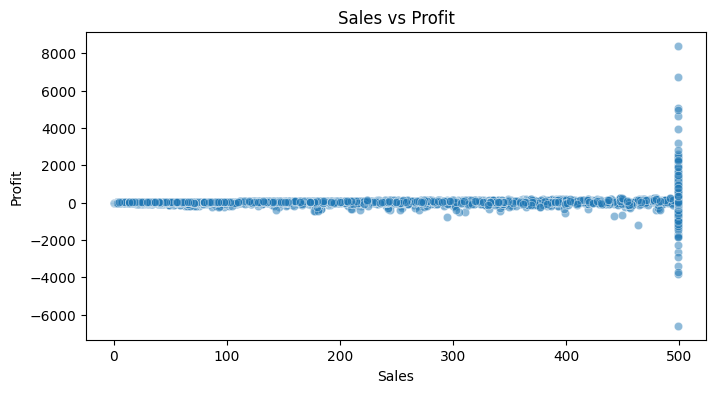

In [22]:
sns.scatterplot(data=df_clean, x="Sales", y="Profit", alpha=0.5)
plt.title("Sales vs Profit")
plt.show()


**Summary:**  
Most orders cluster near small profits, but high-sales orders show much larger variation in profit.  
There is no strong linear relationship between sales and profit.


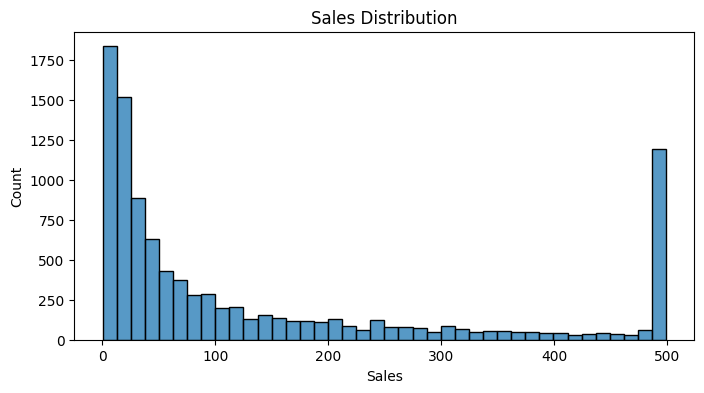

In [23]:
sns.histplot(df_clean["Sales"], bins=40)
plt.title("Sales Distribution")
plt.show()


**Summary:**  
Most orders have low sales amounts, and the frequency drops sharply as sales increase.  
A small number of high-sales orders appear near the upper limit.


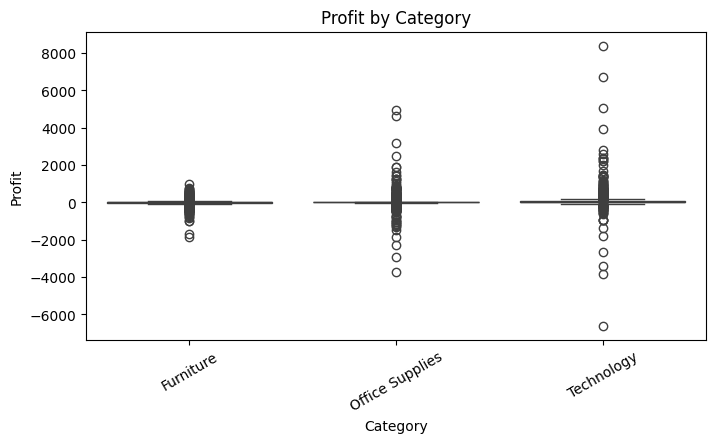

In [24]:
sns.boxplot(data=df_clean, x="Category", y="Profit")
plt.title("Profit by Category")
plt.xticks(rotation=30)
plt.show()


**Summary:**  
Technology shows the widest profit variation, while Furniture and Office Supplies have lower and more stable profits.


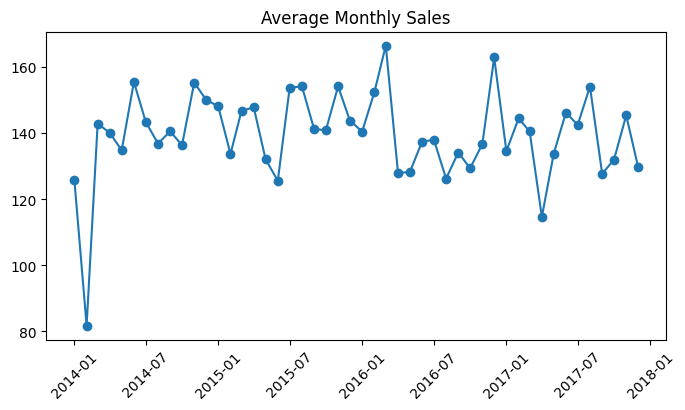

In [25]:
monthly_plot = monthly.copy()
monthly_plot["Order_Month"] = monthly_plot["Order_Month"].dt.to_timestamp()

plt.plot(monthly_plot["Order_Month"], monthly_plot["Sales"], marker="o")
plt.title("Average Monthly Sales")
plt.xticks(rotation=45)
plt.show()


In [ ]:
**Summary:**  
Monthly sales fluctuate within a stable range, with several short-term peaks and dips but no clear long-term trend.


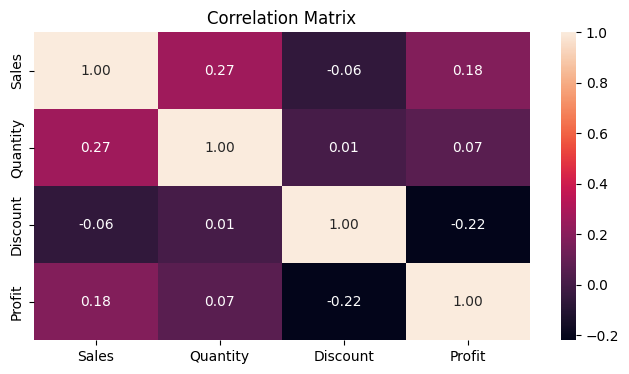

In [26]:
corr = df_clean[["Sales", "Quantity", "Discount", "Profit"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
